In [9]:
# overhead
import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
logger = logging.getLogger(__name__)

# environment parameters
FRAME_TIME = 0.5  # second, time interval
GRAVITY_ACCEL = 10.0  # m/s2, gravity constant
BOOST_ACCEL = 12.0  # m/s2, thrust constant

# define system dynamics

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """
        
        # Apply gravity       
        delta_state_gravity = -t.tensor([0., GRAVITY_ACCEL * FRAME_TIME, 0., 0.])

        # Thrust
        hori = action[1]*math.pi
        delta_state = BOOST_ACCEL * FRAME_TIME * action[0] * (t.tensor([0., 1.0 , 0., 0.]) *math.sin(hori) 
                                                          + t.tensor([0., 0. , 0., 1.0]) *  math.cos(hori))

        # Update velocity
        state = state + delta_state + delta_state_gravity
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0.],
                            [0., 1., 0., 0.],
                            [0., 0., 1., FRAME_TIME],
                            [0., 0., 0., 1.]])
        state = t.matmul(step_mat, state)

        return state

# a deterministic controller

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),#
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

# the simulator that rolls out x(1), x(2), ..., x(T)

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [100.0, 0., 10.0, 0.]  
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2

# set up the optimizer

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        y1 = data[:, 0]
        y2 = data[:, 1]
        x1 = data[:, 2]
        x2 = data[:, 3]
        tt = range(20)
        data1 = np.array([self.simulation.action_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        ac = data1[:, 0]
        an = data1[:, 1]
        plt.plot(x1, y1)
        plt.show()
        #plt.plot(x2, y2)
        #plt.show()
        #plt.plot(tt, ac)
        #plt.show()
        #plt.plot(tt, an)
        #plt.show()


[1] loss: 43626.492


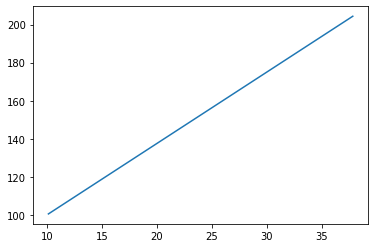

[2] loss: 43626.492


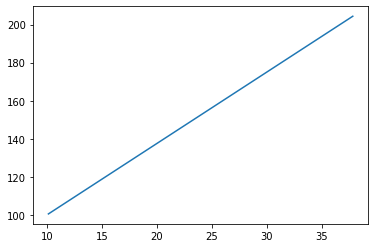

[3] loss: 43626.492


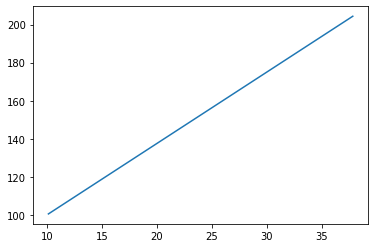

[4] loss: 43626.492


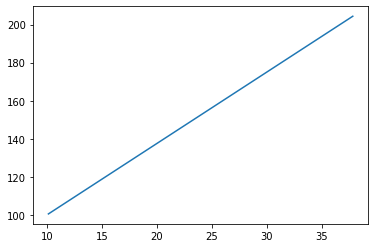

[5] loss: 43626.492


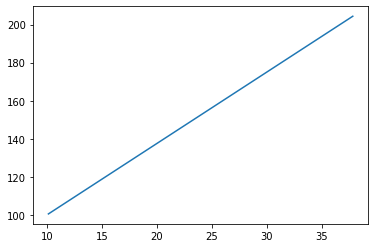

[6] loss: 43626.492


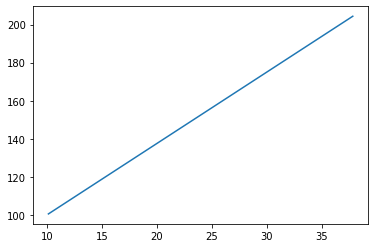

[7] loss: 43626.492


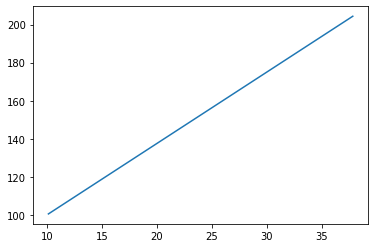

[8] loss: 43626.492


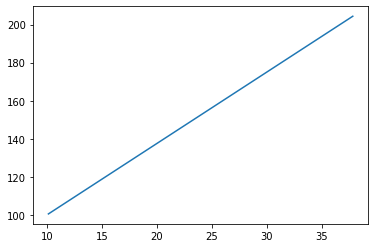

[9] loss: 43626.492


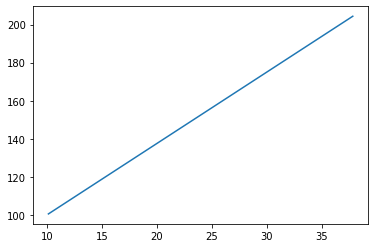

[10] loss: 43626.492


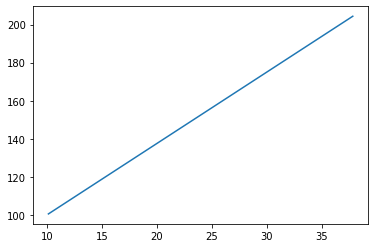

[11] loss: 43626.492


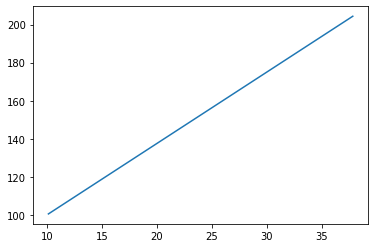

[12] loss: 43626.492


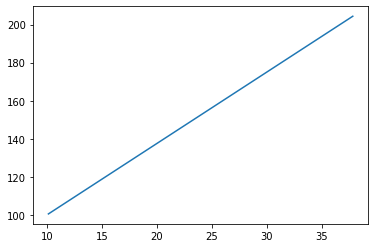

[13] loss: 43626.492


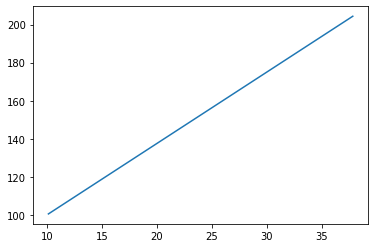

[14] loss: 43626.492


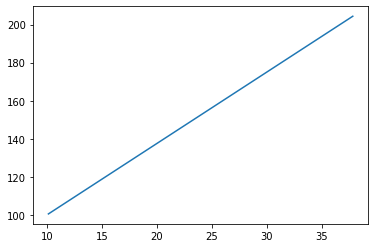

[15] loss: 43626.492


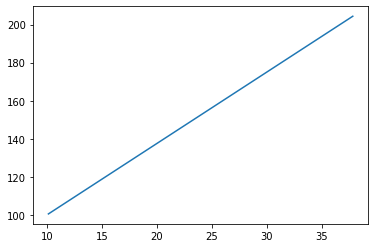

[16] loss: 43626.492


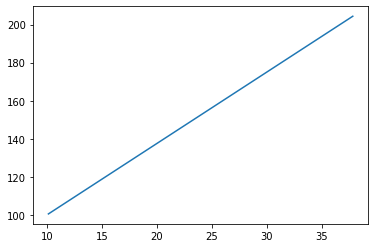

[17] loss: 43626.492


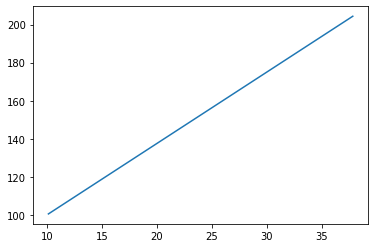

[18] loss: 43626.492


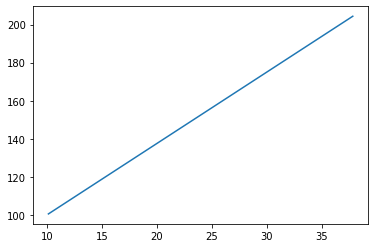

[19] loss: 43626.492


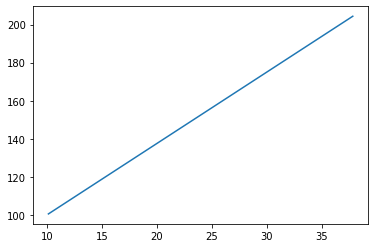

[20] loss: 43626.492


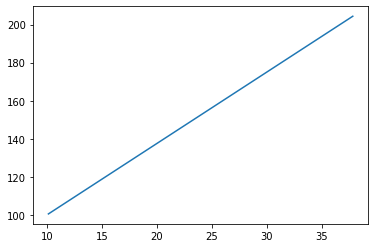

[21] loss: 43626.492


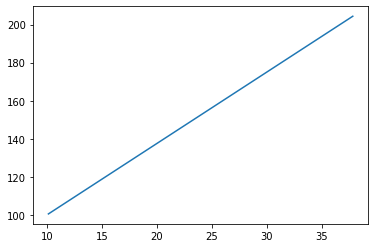

[22] loss: 43626.492


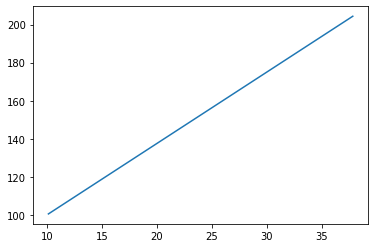

[23] loss: 43626.492


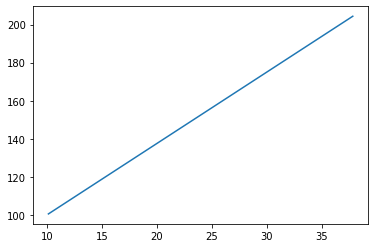

[24] loss: 43626.492


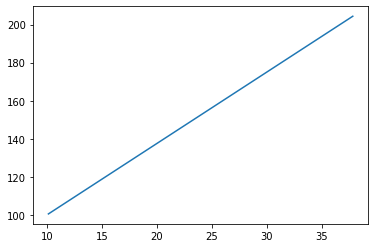

[25] loss: 43626.492


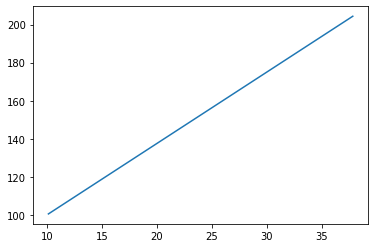

[26] loss: 43626.492


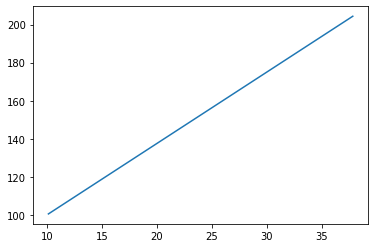

[27] loss: 43626.492


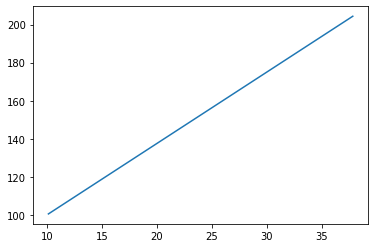

[28] loss: 43626.492


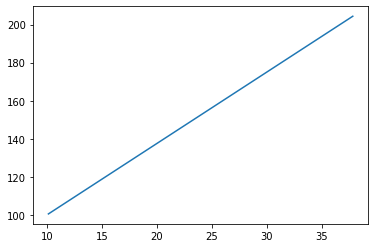

[29] loss: 43626.492


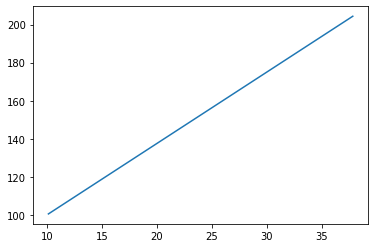

[30] loss: 43626.492


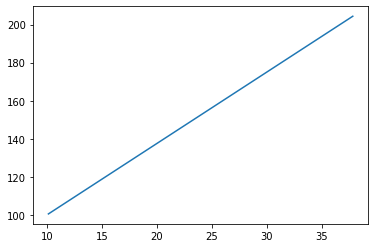

[31] loss: 43626.492


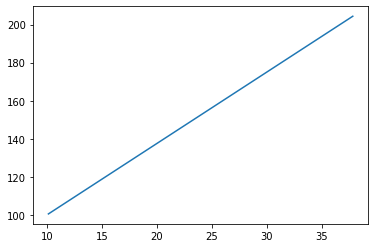

[32] loss: 43626.492


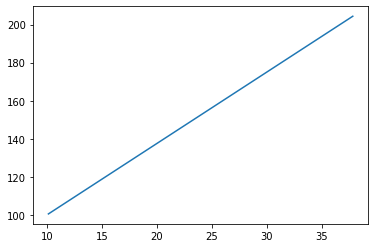

[33] loss: 43626.492


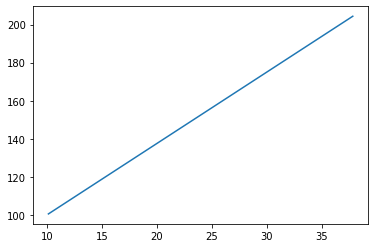

[34] loss: 43626.492


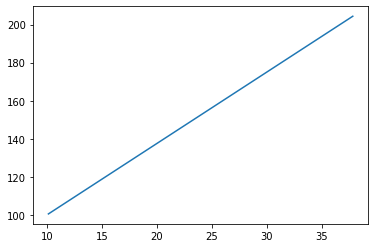

[35] loss: 43626.492


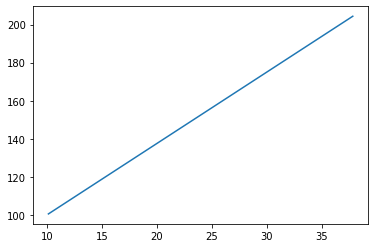

[36] loss: 43626.492


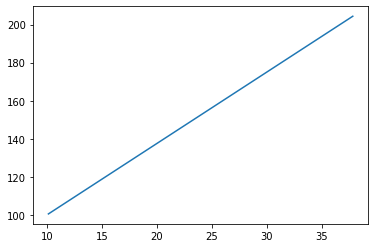

[37] loss: 43626.492


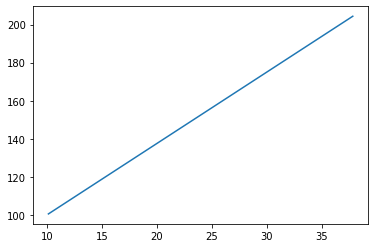

[38] loss: 43626.492


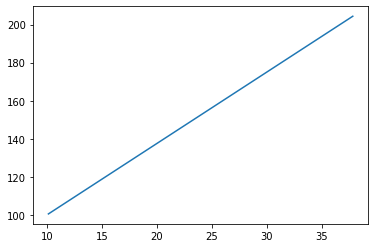

[39] loss: 43626.492


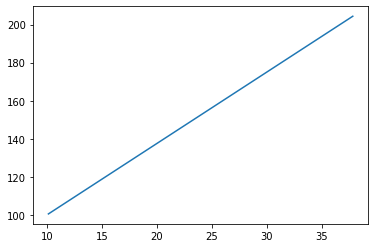

[40] loss: 43626.492


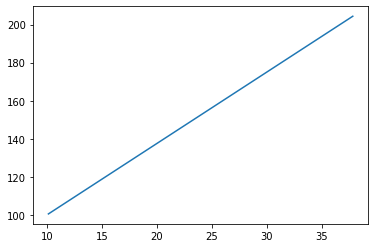

[41] loss: 43626.492


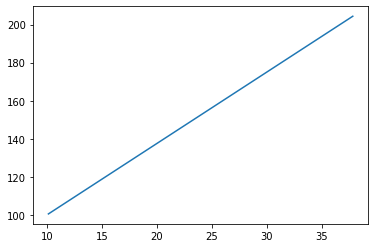

[42] loss: 43626.492


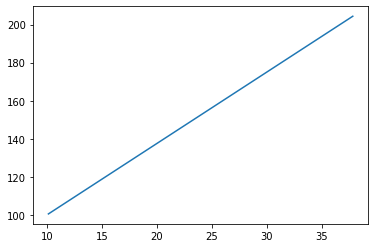

[43] loss: 43626.492


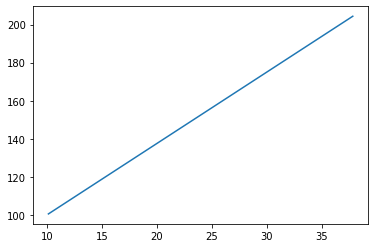

[44] loss: 43626.492


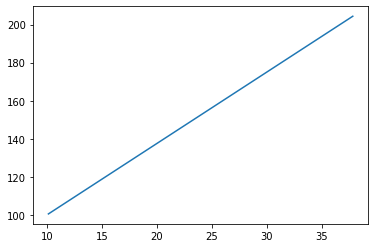

[45] loss: 43626.492


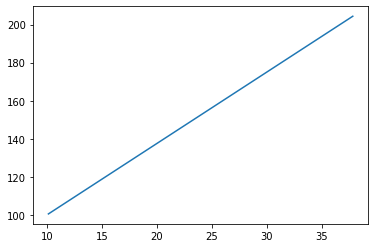

[46] loss: 43626.492


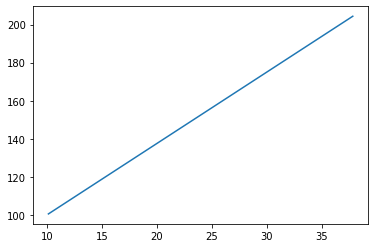

[47] loss: 43626.492


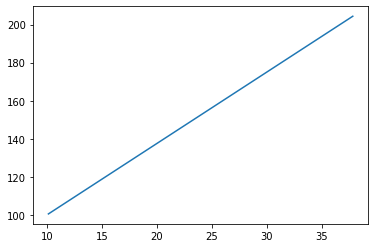

[48] loss: 43626.492


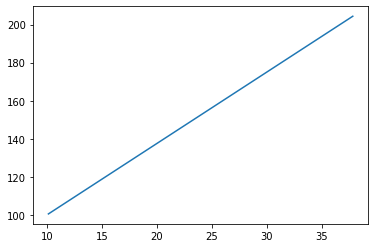

[49] loss: 43626.492


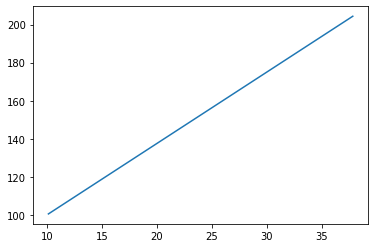

[50] loss: 43626.492


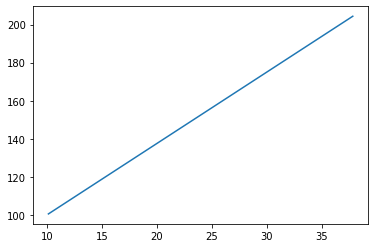

[51] loss: 43626.492


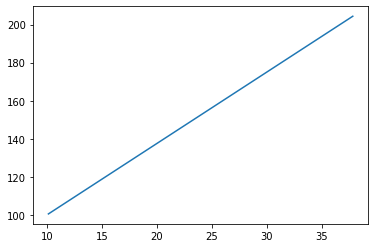

[52] loss: 43626.492


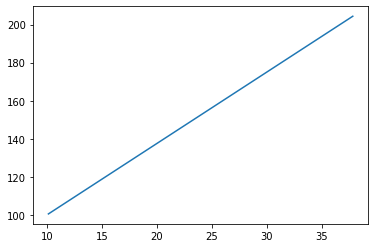

[53] loss: 43626.492


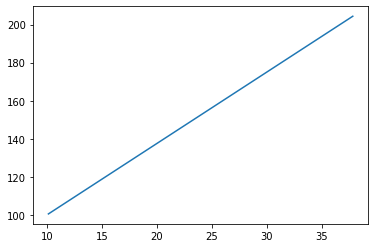

[54] loss: 43626.492


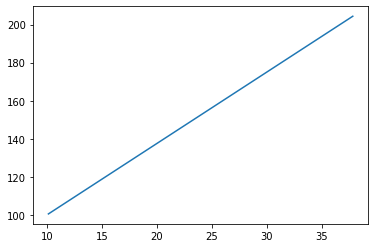

[55] loss: 43626.492


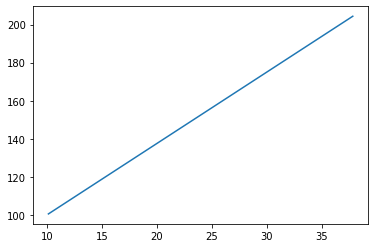

[56] loss: 43626.492


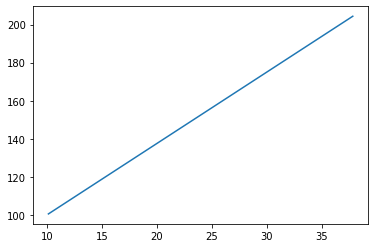

[57] loss: 43626.492


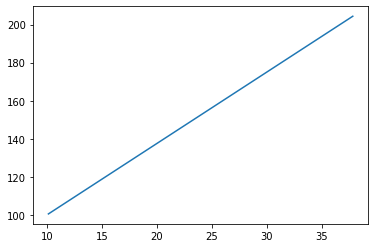

[58] loss: 43626.492


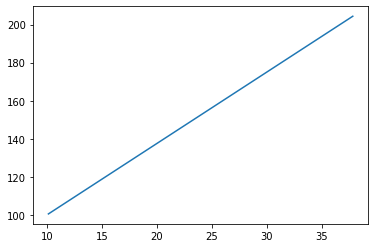

[59] loss: 43626.492


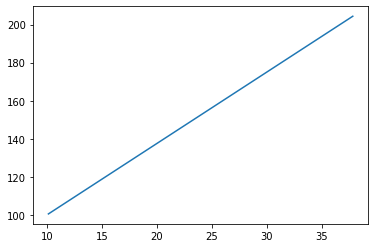

[60] loss: 43626.492


KeyboardInterrupt: 

In [10]:
# Now it's time to run the code!

T = 20  # number of time steps
dim_input = 4  # state space dimensions
dim_hidden = 50  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(200)  # solve the optimization problem

In [ ]:
math.sin(3.141)